In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
from matplotlib import animation
from scipy.misc import imresize
from matplotlib import cm

from libs.utils import *

plt.style.use('ggplot')

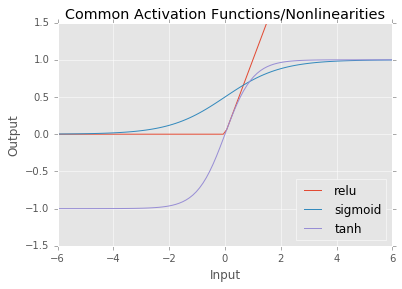

In [2]:
xs = np.linspace(-6, 6, 100)
plt.plot(xs, np.maximum(xs, 0), label='relu')
plt.plot(xs, 1 / (1 + np.exp(-xs)), label='sigmoid')
plt.plot(xs, np.tanh(xs), label='tanh')
plt.xlabel('Input')
plt.xlim([-6, 6])
plt.ylabel('Output')
plt.ylim([-1.5, 1.5])
plt.title('Common Activation Functions/Nonlinearities')
plt.legend(loc='lower right')

In [3]:
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')

In [4]:
W = tf.get_variable('W', shape=(2, 20), dtype=tf.float32,
                    initializer=tf.random_normal_initializer())
h = tf.matmul(X, W)

In [5]:
b = tf.get_variable('b', shape=(20,),  dtype=tf.float32,
                    initializer=tf.constant_initializer(0))
h = tf.nn.bias_add(h, b)

In [6]:
h = tf.nn.relu(h)

In [7]:
def linear(x, n_output, name=None, activation=None, reuse=None):
    if len(x.get_shape()) != 2:
        x = flatten(x)
    
    n_input = x.get_shape().as_list()[1]
    
    with tf.variable_scope(name or 'fc', reuse=reuse):
        W = tf.get_variable('W', shape=[n_input, n_output],
                            initializer=tf.contrib.layers.xavier_initializer())
        
        b = tf.get_variable('b', shape=[n_output],
                            initializer=tf.constant_initializer(0))
        
        h = tf.nn.bias_add(tf.matmul(x, W), b, name='h')
        
        if activation:
            h = activation(h)
            
        return h, W
    
def flatten(x, name=None):
    with tf.variable_scope('flatten'):
        dims = x.get_shape().as_list()
        if len(dims) == 4:
            flattened = tf.reshape(x, shape=[-1, dims[1] * dims[2] * dims[3]])
        elif len(dims) == 2 or len(dims) == 1:
            flattened = x
        else:
            raise ValueError('Expedted n dimensions of 1, 2 or 4. Found:', len(dims))
            
        return flattened

In [8]:
tf.reset_default_graph()

In [9]:
h, W = linear(X, 20, name='linear', activation=tf.nn.relu)

In [10]:
img = plt.imread('bebe.png')
img.shape

(617, 502, 3)

In [11]:
img = imresize(img, (100, 100))

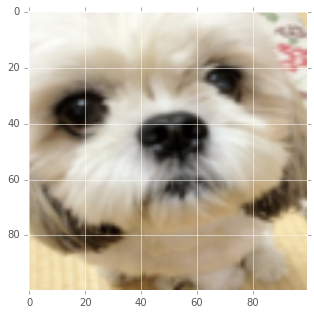

In [12]:
plt.figure(figsize=(5, 5))
plt.imshow(img)

In [13]:
plt.imsave(fname='reference.png', arr=img)

In [14]:
def split_image(img):
    xs = []
    ys = []
    for row_i in range(img.shape[0]):
        for col_i in range(img.shape[1]):
            xs.append([row_i, col_i])
            ys.append(img[row_i, col_i])
    
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

In [15]:
xs, ys = split_image(img)
xs.shape, ys.shape

((10000, 2), (10000, 3))

In [16]:
xs = (xs - xs.mean(0)) / xs.std(0)
np.min(xs), np.max(xs)

(-1.7148160424389376, 1.7148160424389376)

In [17]:
assert np.min(xs) > -3 and np.max(xs) < 3

In [18]:
np.min(ys), np.max(ys)

(0, 253)

In [19]:
ys = ys / 255
np.min(ys), np.max(ys)

(0.0, 0.99215686274509807)

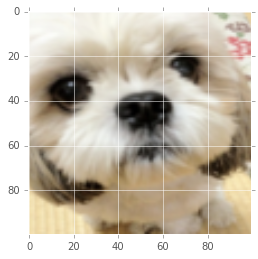

In [20]:
plt.imshow(ys.reshape(img.shape))

In [21]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, (None, 2), 'X')
Y = tf.placeholder(tf.float32, (None, 3), 'Y')

In [22]:
n_neurons = [20, 40, 20, 10, 20, 30, 15]

h1, W1 = linear(X, 20, 'layer1', tf.nn.relu)
for i, n in enumerate(n_neurons, 1):
    exec("h{0}, W{0} = linear(h{1}, {2}, 'layer{0}', tf.nn.relu)"
             .format(i+1, i, n))

In [23]:
Y_pred, W7 = linear(h6, 3, 'pred')

In [24]:
assert X.get_shape().as_list() == [None, 2]
assert Y_pred.get_shape().as_list() == [None, 3]
assert Y.get_shape().as_list() == [None, 3]

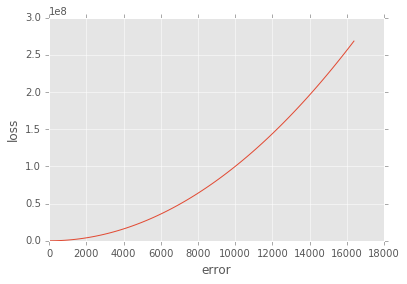

In [25]:
error = np.linspace(0, 128**2, 100)
loss = error**2
plt.plot(error, loss)
plt.xlabel('error')
plt.ylabel('loss')

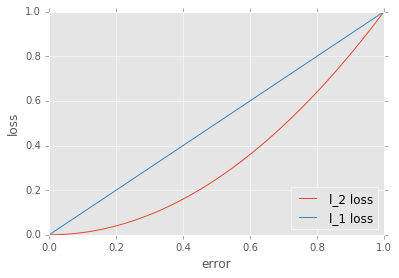

In [26]:
error = np.linspace(0, 1, 100)
plt.plot(error, error**2, label='l_2 loss')
plt.plot(error, np.abs(error), label='l_1 loss')
plt.xlabel('error')
plt.ylabel('loss')
plt.legend(loc='lower right')

In [27]:
# error = tf.abs(Y - Y_pred)
error = tf.squared_difference(Y, Y_pred)
assert error.get_shape().as_list() == [None, 3]

In [28]:
sum_error = tf.reduce_sum(error, 1)
assert sum_error.get_shape().as_list() == [None]

In [29]:
cost = tf.reduce_mean(sum_error)
assert cost.get_shape().as_list() == []

In [30]:
optimizer = tf.train.RMSPropOptimizer(.004).minimize(cost)
n_iterations = 100
batch_size = 500
sess = tf.Session()

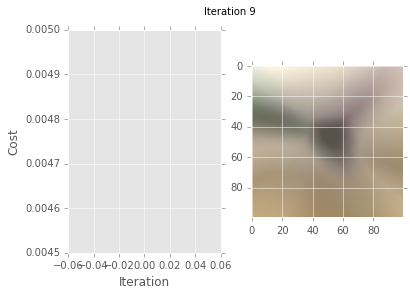

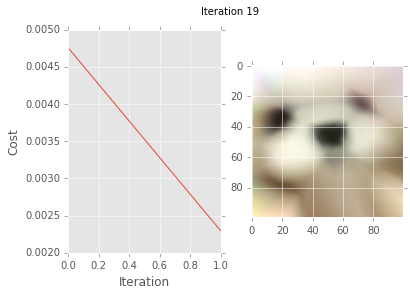

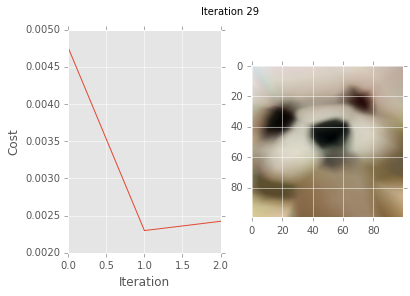

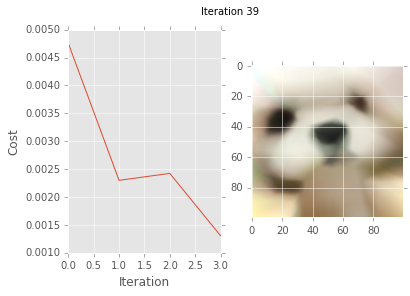

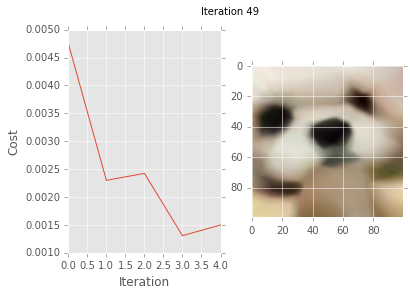

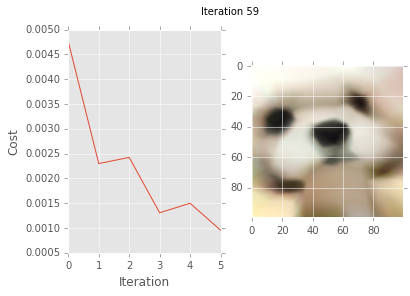

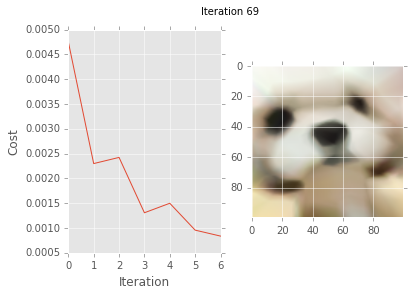

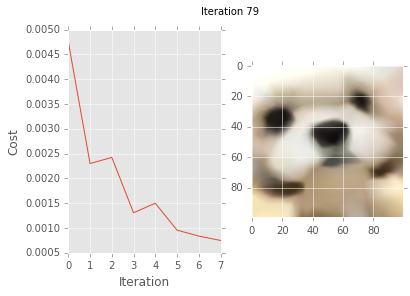

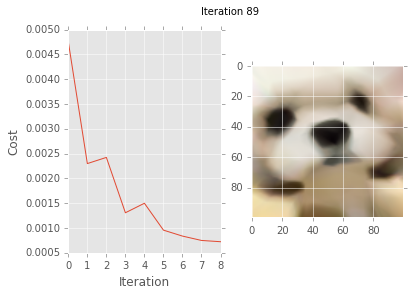

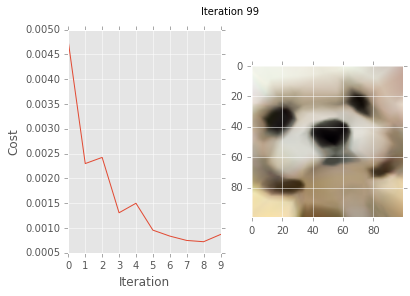

In [31]:
sess.run(tf.initialize_all_variables())

imgs = []
costs = []
gif_step = n_iterations // 10
step_i = 0

for it_i in range(n_iterations):
    idxs = np.random.permutation(range(len(xs)))
    n_batches = len(idxs) // batch_size
    for batch_i in range(n_batches):
        idxs_i = idxs[batch_i * batch_size : (batch_i+1) * batch_size]
        
        training_cost = sess.run([cost, optimizer],
                                 feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})[0]
        
    if (it_i+1) % gif_step == 0:
        costs.append(training_cost / n_batches)
        ys_pred = Y_pred.eval(feed_dict={X: xs}, session=sess)
        img = np.clip(ys_pred.reshape(img.shape), 0, 1)
        imgs.append(img)
        
        fig, ax = plt.subplots(1, 2)
        ax[0].plot(costs)
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Cost')
        ax[1].imshow(img)
        fig.suptitle('Iteration {}'.format(it_i))
        plt.show()

In [32]:
def build_gif(imgs, interval=.1, dpi=72, save_gif=True, 
              saveto='animation.gif', show_gif=False, cmap=None):
    imgs = np.asarray(imgs)
    h, w, *c = imgs[0].shape
    fig, ax = plt.subplots(figsize=(np.round(w / dpi), np.round(h / dpi)))
    fig.subplots_adjust(bottom=0)
    fig.subplots_adjust(top=1)
    fig.subplots_adjust(right=1)
    fig.subplots_adjust(left=0)
    ax.set_axis_off()
    
    if cmap:
        axs = list(map(lambda x: [ax.imshow(x, cmap=cmap)], imgs))
    else:
        axs = list(map(lambda x: [ax.imshow(x)], imgs))
        
    ani = animation.ArtistAnimation(fig, axs, interval=interval, 
                                    repeat_delay=0, blit=False)
    if save_gif:
        try:
            ani.save(saveto, writer='imagemagick', dpi=dpi)
        except Exception as e:
            print(e)
            print('You do not have imagemagick installed.')
            
    if show_gif:
        plt.show()
        
    return ani

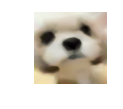

In [33]:
build_gif(imgs, saveto='single.gif')
ipyd.Image(url='single.gif?{}'.format(np.random.rand()),
           height=500, width=500)

In [34]:
def build_model(xs, ys, n_neurons, n_layers, activation_fn,
                final_activation_fn, cost_type):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    if xs.ndim != 2:
        raise ValueError('xs should be a n_observates x '
                         'n_features, or a 2-dimensional array.')
    if ys.ndim != 2:
        raise ValueError('ys should be a n_observates x '
                         'n_features, or a 2-dimensional array.')
    n_xs = xs.shape[1]
    n_ys = ys.shape[1]
    
    X = tf.placeholder(name='X', shape=[None, n_xs],
                       dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape=[None, n_ys],
                       dtype=tf.float32)
    
    current_input = X
    for layer_i in range(n_layers):
        current_input = linear(current_input, n_neurons, 
                               'layer%d' % layer_i, activation_fn)[0]
        
    Y_pred = linear(current_input, n_ys, 'pred', final_activation_fn)[0]
    
    if cost_type == 'l1_norm':
        cost = tf.reduce_mean(tf.reduce_sum(tf.abs(Y - Y_pred), 1))
    elif cost_type == 'l2_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                    tf.squared_difference(Y, Y_pred), 1))
    else:
        raise ValueError('Unknown cost_type: %s. Use only '
                         '"l1_norm" or "l2_norm"' % cost_type)
        
    return {'X': X, 'Y': Y, 'Y_pred': Y_pred, 'cost': cost}

In [35]:
def train(imgs, learning_rate=.0001, batch_size=200,
          n_iterations=10, gif_step=2, n_neurons=30,
          n_layers=10, activation_fn=tf.nn.relu,
          final_activation_fn=tf.nn.tanh, cost_type='l2_norm'):
    
    N, H, W, C = imgs.shape
    all_xs, all_ys = [], []
    for img_i, img in enumerate(imgs):
        xs, ys = split_image(img)
        all_xs.append(np.c_[xs, np.repeat(img_i, [xs.shape[0]])])
        all_ys.append(ys)
    xs = np.array(all_xs).reshape(-1, 3)
    xs = (xs - np.mean(xs, 0)) / np.std(xs, 0)
    ys = np.array(all_ys).reshape(-1, 3)
    ys = ys / 127.5 - 1
    
    g = tf.Graph()
    with tf.Session(graph=g) as sess:
        model = build_model(xs, ys, n_neurons, n_layers, activation_fn, 
                            final_activation_fn, cost_type)
        optimizer = tf.train.AdamOptimizer(
                        learning_rate).minimize(model['cost'])
        sess.run(tf.initialize_all_variables())
        gifs = []
        costs = []
        step_i = 0
        for it_i in range(n_iterations):
            idxs = np.random.permutation(range(len(xs)))
            
            n_batches = len(idxs) // batch_size
            training_cost = 0
            
            for batch_i in range(n_batches):
                idxs_i = idxs[batch_i * batch_size : 
                              (batch_i + 1) * batch_size]
                
                cost = sess.run([model['cost'], optimizer], feed_dict={
                            model['X']: xs[idxs_i], model['Y']: ys[idxs_i]
                        })[0]
                training_cost += cost
                
            print('iteration {}/{}: cost {}'.format(it_i + 1, n_iterations,
                                                    training_cost / n_batches))
            
            if (it_i + 1) % gif_step == 0:
                costs.append(training_cost / n_batches)
                ys_pred = model['Y_pred'].eval(feed_dict={
                        model['X']: xs}, session=sess)
                img = ys_pred.reshape(imgs.shape)
                gifs.append(img)
        return gifs

In [36]:
np.array(celeb_imgs).shape

(100, 218, 178, 3)

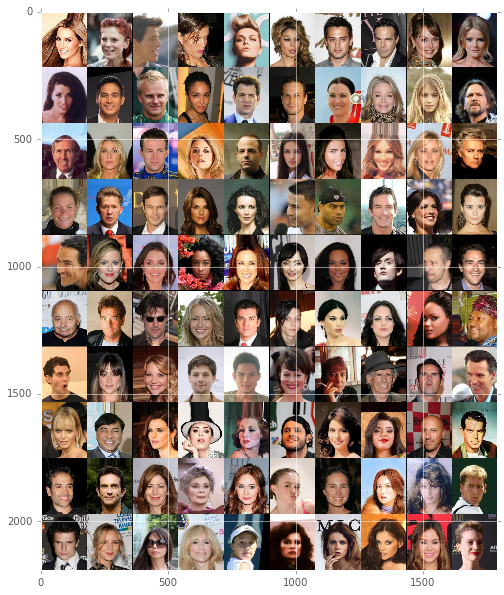

In [37]:
celeb_imgs = get_celeb_imgs()
plt.figure(figsize=(10, 10))
plt.imshow(montage(celeb_imgs).astype(np.uint8))

imgs = np.array(celeb_imgs).copy()

In [38]:
gifs = train(imgs)

iteration 1/10: cost 0.9189038427081775
iteration 2/10: cost 0.8946731955276889
iteration 3/10: cost 0.8823230797335629
iteration 4/10: cost 0.8713155862425126
iteration 5/10: cost 0.8621539054132223
iteration 6/10: cost 0.8534940821327459
iteration 7/10: cost 0.8444282983476483
iteration 8/10: cost 0.8358450017200525
iteration 9/10: cost 0.828271164809683
iteration 10/10: cost 0.8207971951559934


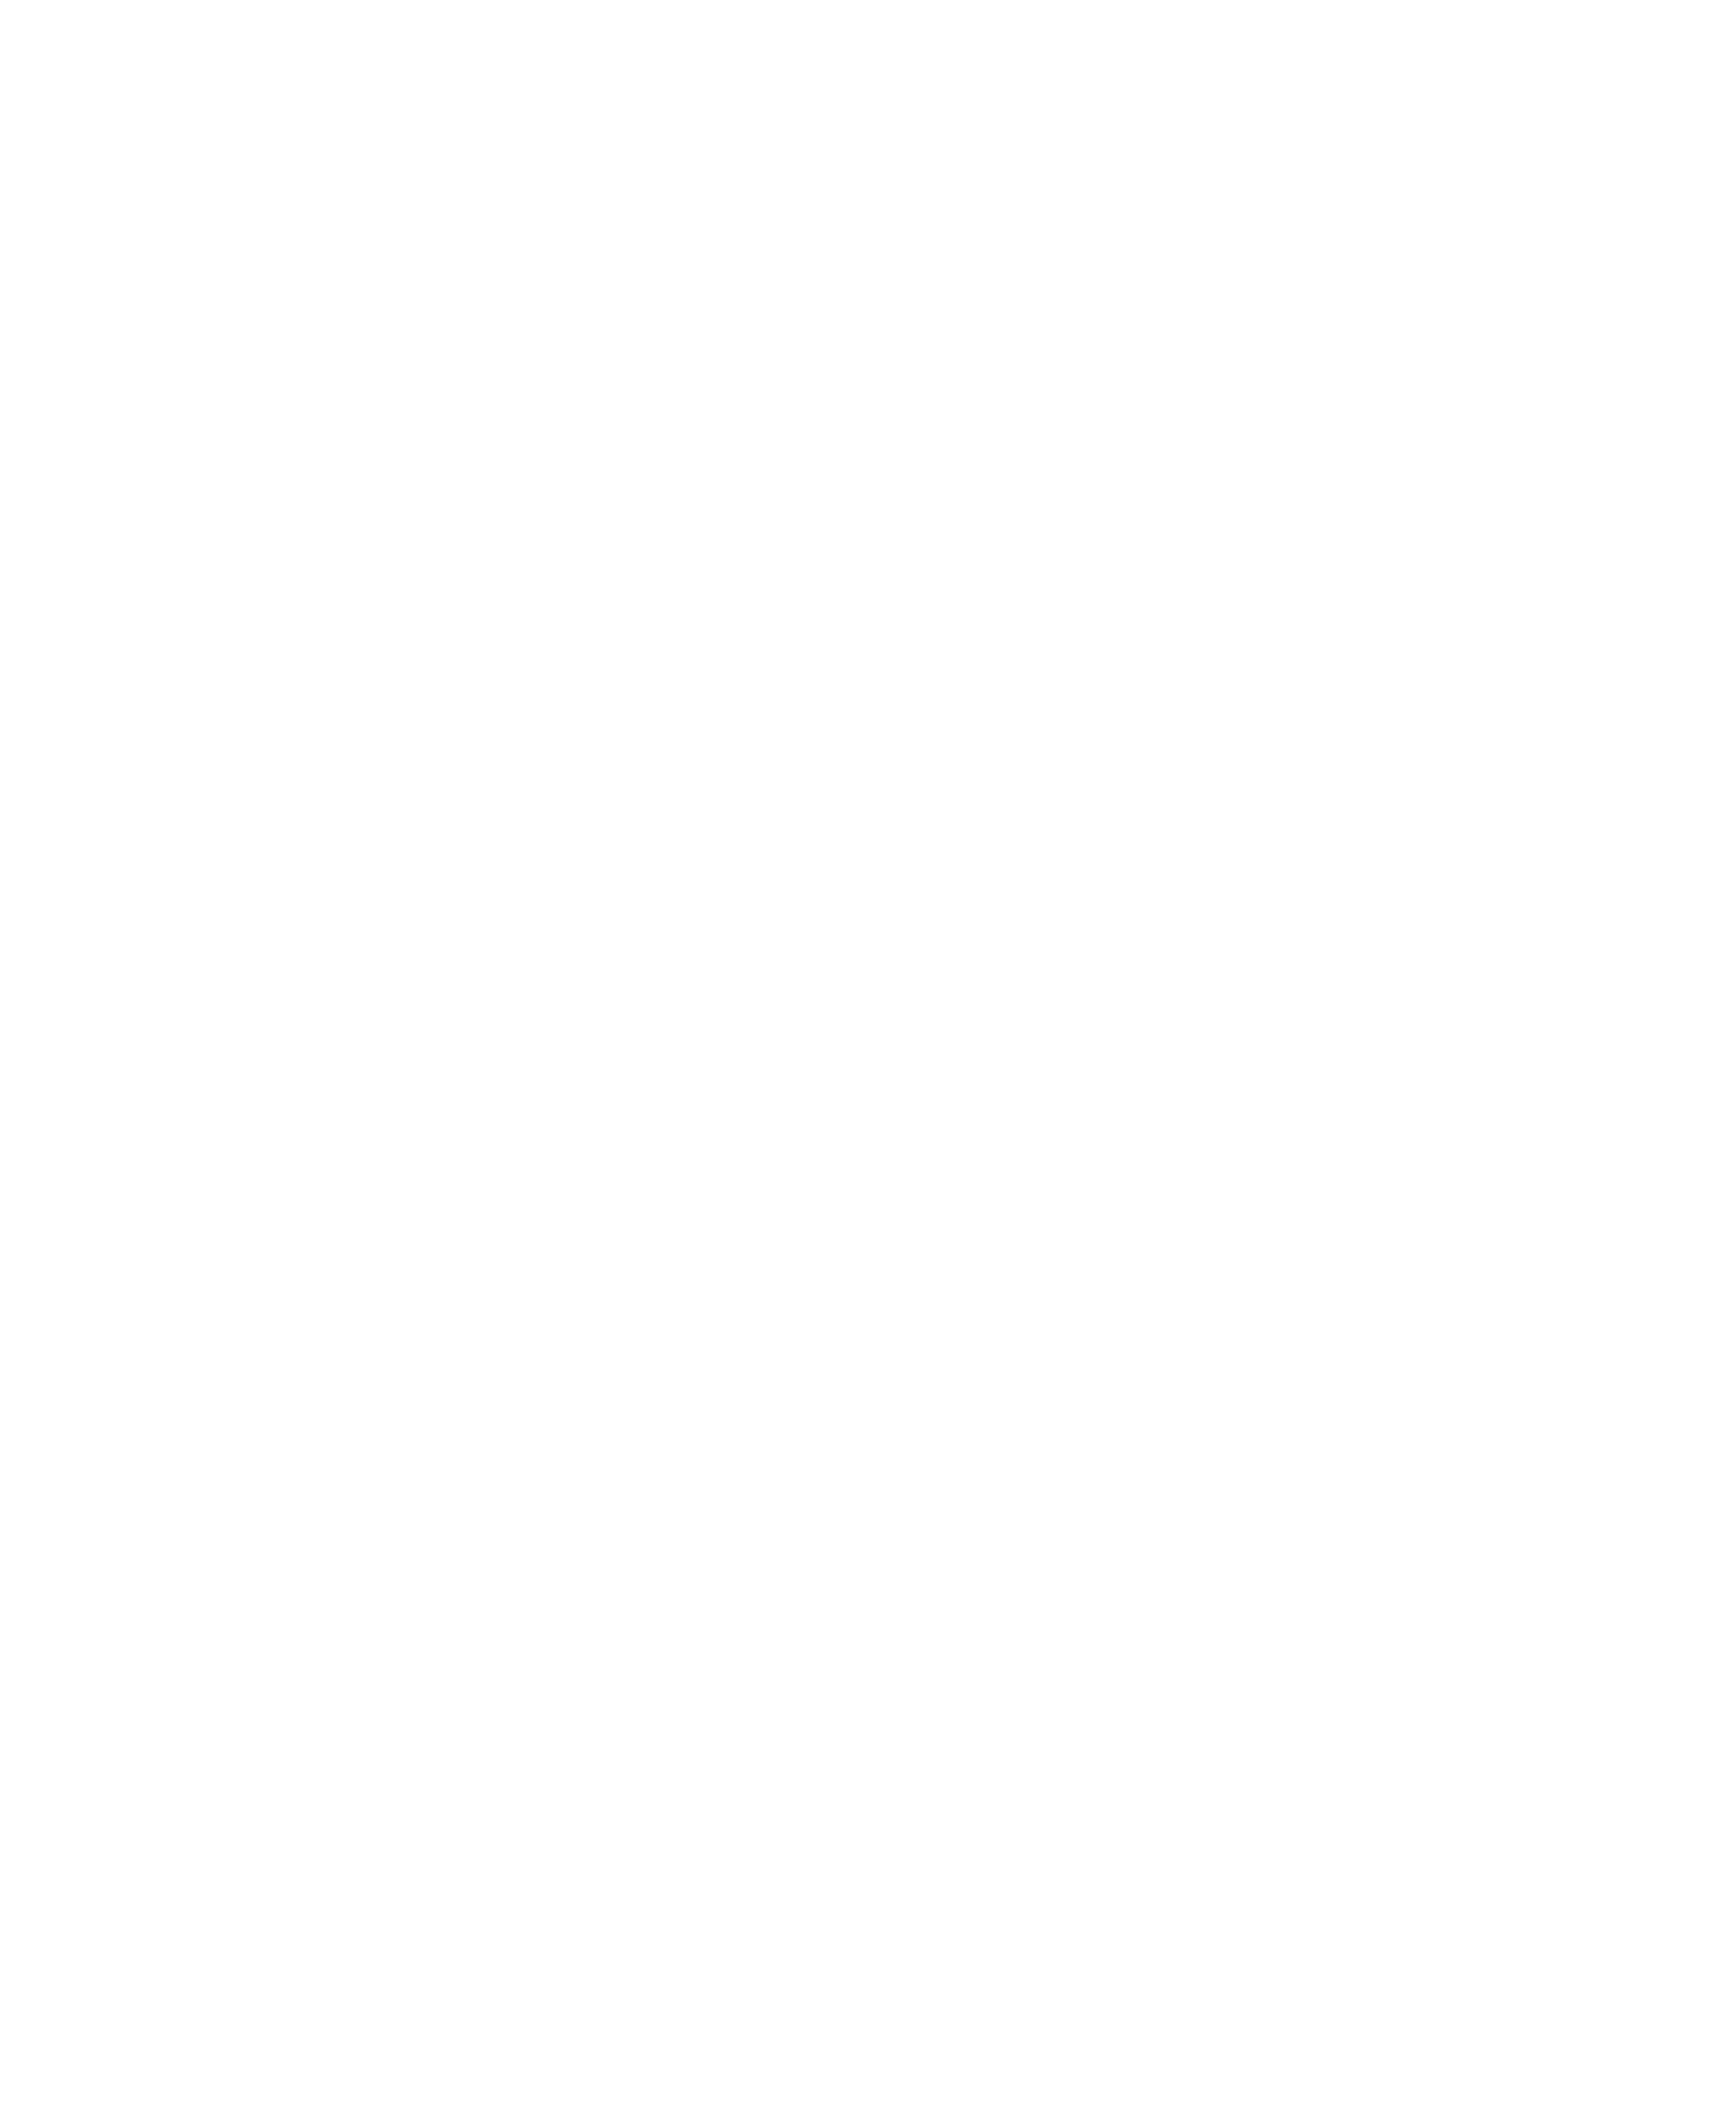

In [39]:
montage_gifs = [np.clip(montage((m * 127.5) + 127.5), 0, 255
                       ).astype(np.uint8) for m in gifs]
build_gif(montage_gifs, saveto='multiple.gif')

In [40]:
ipyd.Image(url='multiple.gif?{}'.format(np.random.rand()),
           height=500, width=500)

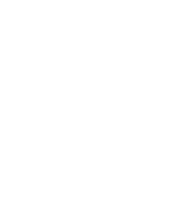

In [41]:
final = gifs[-1]
final_gif = [np.clip((m * 127.5) + 127.5, 0, 255
                    ).astype(np.uint8) for m in final]
build_gif(final_gif, saveto='final.gif')

In [42]:
ipyd.Image(url='final.gif?{}'.format(np.random.rand()),
           height=200, width=200)

In [43]:
dirname = 'jolies/'
filenames = [dirname + fname for fname in os.listdir(dirname) if fname.endswith('.jpg')]
imgs = [plt.imread(fname)[:, :, :3] for fname in filenames]
imgs = [imcrop_tosquare(img_i) for img_i in imgs]
imgs = [resize(img_i, (100, 100)) for img_i in imgs]
imgs = np.array(imgs).astype(np.float32)

In [44]:
imgs.min(), imgs.max()

(0.0, 1.0)

In [45]:
imgs = imgs * 255

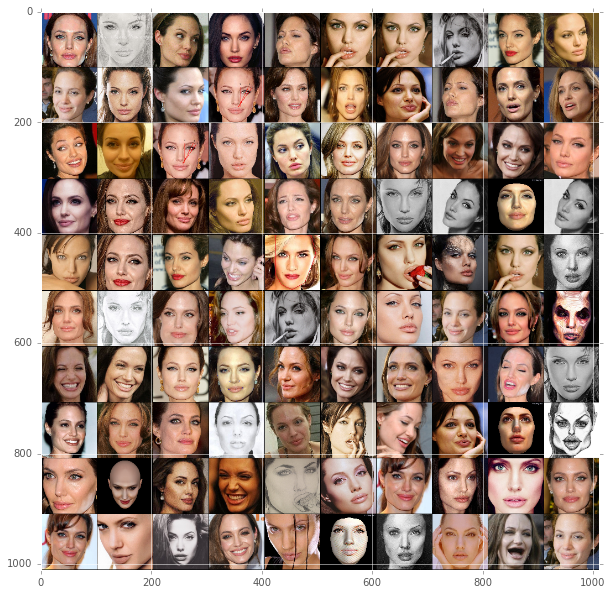

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(montage(imgs).astype(np.uint8))

In [47]:
gifs = train(imgs)

iteration 1/10: cost 0.7406431775331497
iteration 2/10: cost 0.7122902127563954
iteration 3/10: cost 0.702666339302063
iteration 4/10: cost 0.6959659415841103
iteration 5/10: cost 0.6913690275907517
iteration 6/10: cost 0.6874845647931099
iteration 7/10: cost 0.6837400181770324
iteration 8/10: cost 0.6802928061783313
iteration 9/10: cost 0.6768498777389527
iteration 10/10: cost 0.6740156990647316


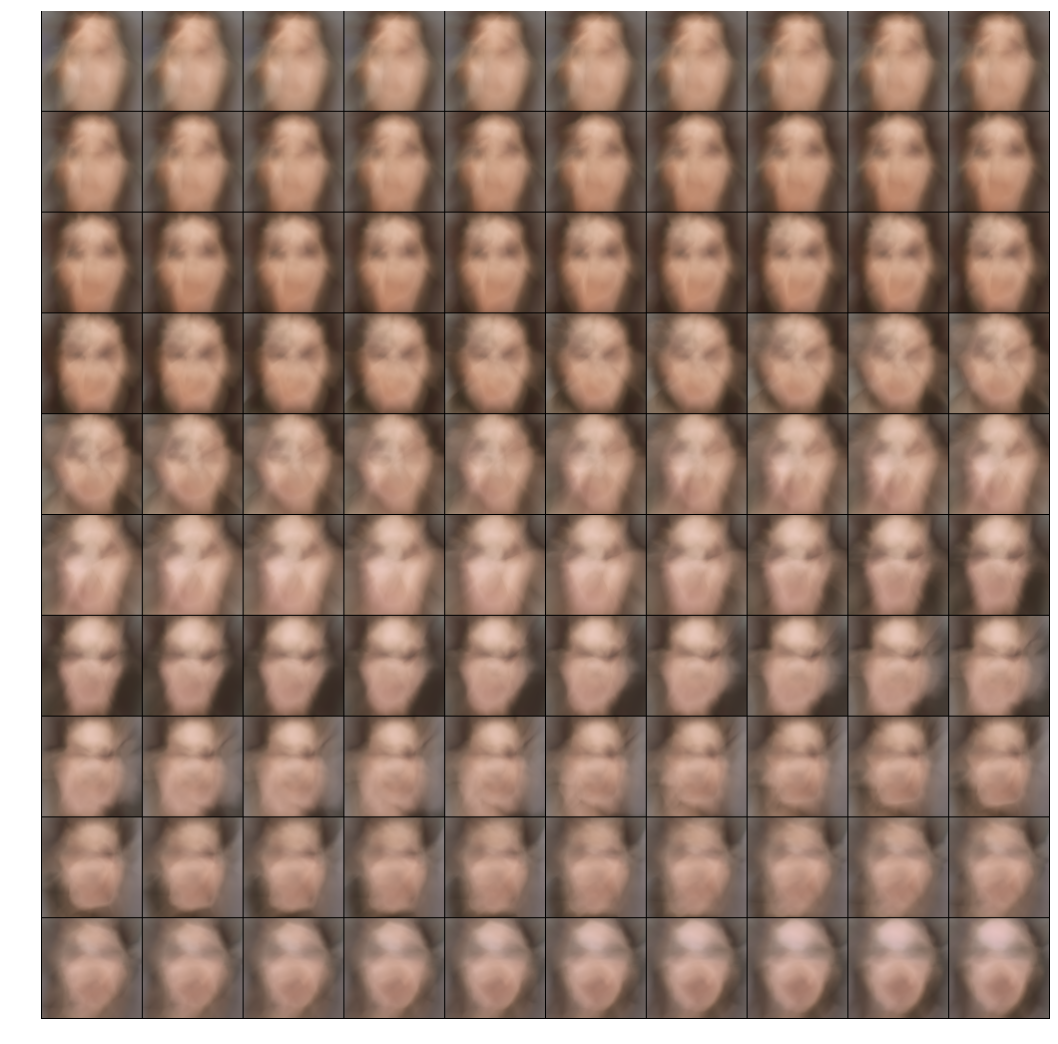

In [48]:
montage_gifs = [np.clip(montage((m * 127.5) + 127.5), 0, 255
                       ).astype(np.uint8) for m in gifs]
build_gif(montage_gifs, saveto='multiple.gif')
ipyd.Image(url='multiple.gif?{}'.format(np.random.rand()),
           height=500, width=500)

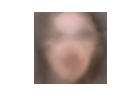

In [49]:
final = gifs[-1]
final_gif = [np.clip((m * 127.5) + 127.5, 0, 255
                    ).astype(np.uint8) for m in final]
build_gif(final_gif, saveto='final.gif')
ipyd.Image(url='final.gif?{}'.format(np.random.rand()),
           height=200, width=200)

In [50]:
all_xs, all_ys = [], []
for img_i, img in enumerate(imgs):
    xs, ys = split_image(img)
    all_xs.append(np.c_[xs, np.repeat(img_i, [xs.shape[0]])])
    all_ys.append(ys)

In [51]:
np.array(all_xs).shape

(100, 10000, 3)

In [52]:
xs = np.array(all_xs).reshape(-1, 3).astype('float32')
xs.min(), xs.max()

(0.0, 99.0)

In [53]:
xs = (xs - xs.mean(0)) / xs.std(0)
xs.min(), xs.max()

(-1.7138871, 1.7260426)

In [54]:
ys = np.array(all_ys).reshape(-1, 3).astype('float32')
ys.min(), ys.max()

(0.0, 255.0)

In [55]:
ys = ys / 127.5 - 1
ys.min(), ys.max()

(-1.0, 1.0)

In [57]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [58]:
tf.reset_default_graph()
sess = tf.Session()

W_conv1 = weight_variable([25, 25, 3, 3])
b_conv1 = bias_variable([3])

y_image = tf.reshape(ys, [-1,100,100,3])

h_conv1 = tf.nn.relu(conv2d(y_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([50, 50, 3, 3200])
b_conv2 = bias_variable([3200])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([10, 3])
b_fc1 = bias_variable([3])

h_pool2_flat = tf.reshape(h_pool2, [-1, 10])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [60]:
# tf.reset_default_graph()
# sess = tf.Session()
X = tf.placeholder(tf.float32, name='X', shape=(None, 3))
Y = tf.placeholder(tf.float32, name='Y', shape=(None, 3))
current_input = X
n_neurons = [24, 50, 50, 24]
for layer_i, n_neuron in enumerate(n_neurons):
    with tf.variable_scope('layer%d'%layer_i):
        W = tf.get_variable(name='W', shape=[current_input.get_shape()[-1], n_neuron],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(name='b', shape=[n_neuron],
                            initializer=tf.constant_initializer(0))
        
        h = tf.nn.bias_add(name='h', value=tf.matmul(current_input, W), bias=b)
        h = tf.nn.relu(h)
        
    current_input = h

In [61]:
with tf.variable_scope('pred'):
    W = tf.get_variable(name='W', shape=[current_input.get_shape()[-1], 3],
                        initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable(name='b', shape=[3], initializer=tf.constant_initializer(0))
    Y_pred = tf.nn.bias_add(name='Y_pred', value=tf.matmul(current_input, W), bias=b)
    Y_pred = tf.nn.tanh(Y_pred)

In [62]:
cost = tf.reduce_mean(tf.reduce_sum(tf.squared_difference(Y, Y_pred), 1))
# cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(Y_pred), 1))

In [63]:
learning_rate = .001
n_iterations = 10
batch_size = 1000000
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [64]:
sess.run(tf.initialize_all_variables())
gifs = []
costs = []
gif_step = 1
for it_i in range(n_iterations):
    idxs = np.random.permutation(range(len(xs)))
    
    n_batches = len(idxs) // batch_size
    training_cost = 0
    
    for batch_i in range(n_batches):
        idx_i = idxs[batch_i * batch_size : (batch_i + 1) * batch_size]
        
        h = h_fc1_drop.eval(feed_dict={keep_prob: 1.}, session=sess)
        _cost = sess.run([cost, optimizer], feed_dict={
                            X: xs[idx_i], Y: h[idx_i], keep_prob: 1.})[0]
        training_cost += _cost
        
    print('iteration {}/{}: cost {}'.format(it_i+1, n_iterations, 
                                            training_cost/n_batches))    
    if (it_i + 1) % gif_step == 0:
        costs.append(training_cost / n_batches)
        ys_pred = Y_pred.eval(feed_dict={X: xs, keep_prob: 1.}, session=sess)
        img = ys_pred.reshape(imgs.shape)
        gifs.append(img)

iteration 1/10: cost 2.6922523975372314
iteration 2/10: cost 2.5767574310302734
iteration 3/10: cost 2.472809076309204
iteration 4/10: cost 2.3810932636260986
iteration 5/10: cost 2.302907943725586
iteration 6/10: cost 2.238569736480713
iteration 7/10: cost 2.185070276260376
iteration 8/10: cost 2.140277862548828
iteration 9/10: cost 2.1019179821014404
iteration 10/10: cost 2.0682287216186523


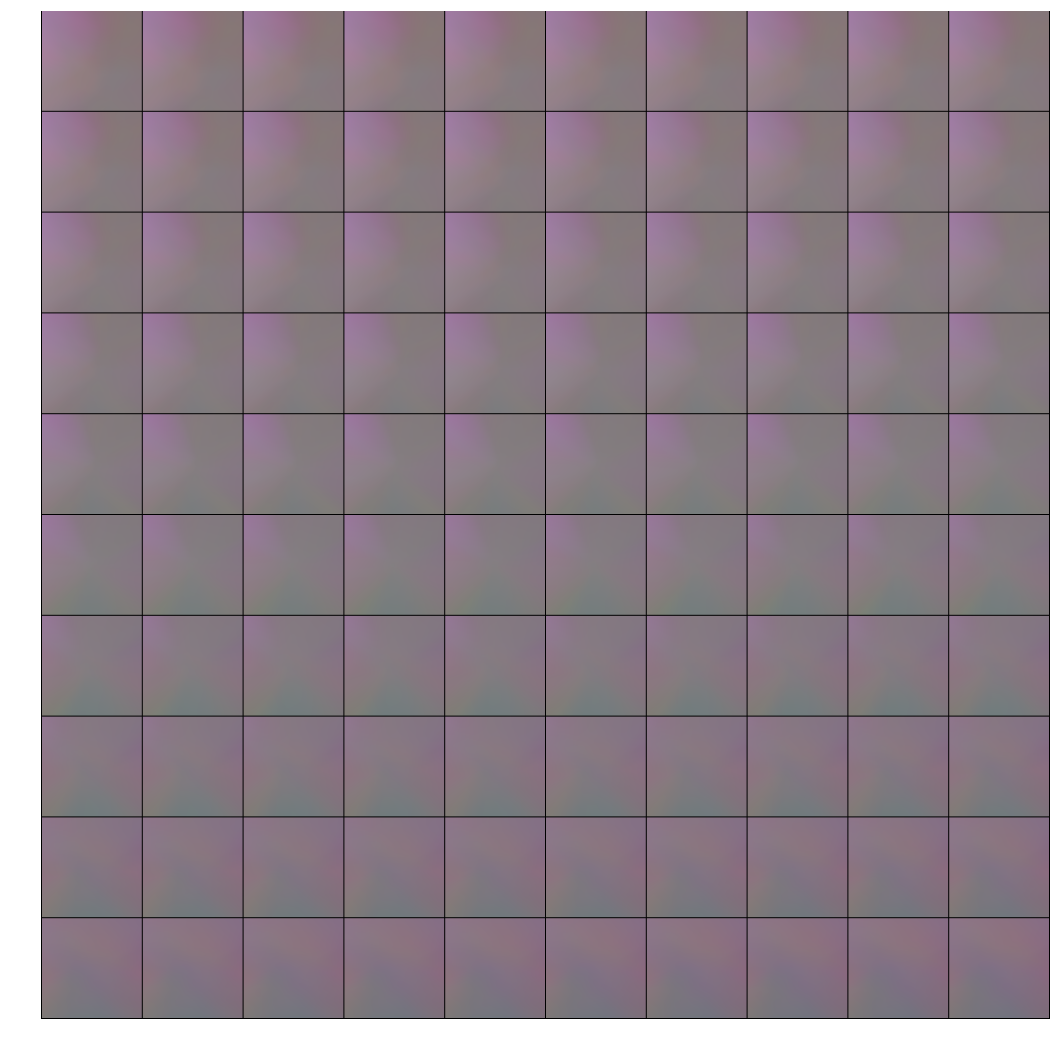

In [65]:
montage_gifs = [np.clip(montage(m * 127.5 + 127.5), 0, 255).astype(np.uint8) for m in gifs]
build_gif(montage_gifs, saveto='explore.gif')

ipyd.Image(url='explore.gif?{}'.format(np.random.rand()),
           height=500, width=500)

In [66]:
build_submission('session-2.zip',
                       ('reference.png',
                        'single.gif',
                        'multiple.gif',
                        'final.gif',
                        'session-2.ipynb'),
                       ('explore.gif'))

Your assignment zip file has been created!
Now submit the file:
/Users/km/Dropbox/notebooks/kadenze/CADL/session-2/session-2.zip
to Kadenze for grading!
